MEM T380

Case Studies Group 10

Ante Sokosa  
Ziad Hatab

Final Project - Weld Defect Classification with Aritifial Neural Networks

In [1]:
# for calculating notebook runtime
import time
start_time = time.time()

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import pandas as pd
from pandas.api.types import CategoricalDtype

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
import numpy as np

# 1 &nbsp; `Data Exploration (Access, Preprocessimg, and Deriving Features`

Data exploration has been previously explained, discussed, and completed in HW2.  
We are importing this data as explored, cleaned, and prepared with subsets combined.

In [4]:
excel_file = 'weld_defect_dataset.xlsx'

# gather data from excel file
subsets = []
for i in range(1, 6):
    subset = pd.read_excel(excel_file, sheet_name = 'subset' + str(i))
    subset = subset.rename(columns={'Type':'type','W':'w','Ar':'ar','Sp':'sp','Re':'re','Rr':'rr','Sk':'sk','Ku':'ku','Hc':'hc','Rc':'rc','Sc ':'sc','Kc ':'kc'}) # note the space after Sc and Kc are errors in naming in the excel file and are corrected here for ease of use later
    subsets.append(subset)
df = pd.concat(subsets, ignore_index=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Features
nums = list(df.select_dtypes(include=['float64']).columns)
standard_scaler = MinMaxScaler()
df[nums] = standard_scaler.fit_transform(df[nums])

# Target
types = df['type'].unique().tolist()
print('types:',types)
cat_type = CategoricalDtype(categories=types, ordered=True) # specify the order of categories (stop it from going in alphabetical order; good for confusion matricies comparisons to paper later)
df['type'] = df['type'].astype(cat_type) # convert column to categorical type
df['type_copy'] = df['type'] # create column for get_dummies() to work on so that we keep the orignal 'type' columns afterwards
df = pd.get_dummies(df, columns=['type_copy'], prefix=['type']) # get dummies

excel_file_clean = excel_file.split('.')[0]+'_clean.xlsx'
df.to_excel(excel_file_clean, index=False)
df # clean and prepped dataframe

types: ['PO', 'SL', 'LP', 'LF', 'CR']


,type,w,ar,sp,re,rr,sk,ku,hc,rc,sc,kc,type_PO,type_SL,type_LP,type_LF,type_CR
0,PO,0.007173,0.003334,0.548722,0.832328,0.994608,0.090125,0.715208,0.002991,0.107479,0.255421,0.362612,1,0,0,0,0
1,PO,0.008608,0.000000,0.385383,0.832328,0.646705,0.037535,0.297494,0.002672,0.117505,0.331335,0.416629,1,0,0,0,0
2,PO,0.005738,0.000000,0.414137,1.000000,0.751293,0.046435,0.577857,0.002485,0.123983,0.321786,0.417361,1,0,0,0,0
3,PO,0.027259,0.000000,0.286741,0.530516,0.061263,0.243005,0.599790,0.009525,0.088756,0.218969,0.312173,1,0,0,0,0
4,PO,0.017217,0.000000,0.376597,0.552859,0.037085,0.576723,0.446455,0.006427,0.069984,0.269595,0.245306,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,CR,0.276901,0.914287,1.000000,0.101609,0.720118,0.023399,0.289891,0.096535,0.755706,0.230090,0.489335,0,0,0,0,1
215,CR,0.147776,0.693334,0.790735,0.054577,0.507429,0.133745,0.369796,0.010367,0.258734,0.409571,0.503984,0,0,0,0,1
216,CR,0.319942,0.814814,0.683706,0.105508,0.406227,0.025910,0.308671,0.182592,0.755570,0.157137,0.532249,0,0,0,0,1
217,CR,0.321378,0.555773,0.615815,0.142103,0.382799,0.038095,0.313170,0.147628,0.638405,0.217197,0.541198,0,0,0,0,1


For Reference: 

`Defect Features:`

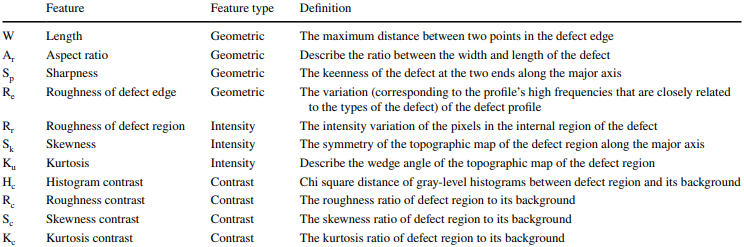

`Defect Types:`  
- `CR` = crack
- `LF` = lack of fusion
- `LP` = lack of penetration
- `PO` = porosity
- `SL` = slag inclusion

`Defect Types:`  
- `PO` = porosity
- `SL` = slag inclusion
- `LP` = lack of penetration
- `LF` = lack of fusion
- `CR` = crack


Useing `.info()` and `.describe()` for data confirmation and reference:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   type     219 non-null    category
 1   w        219 non-null    float64 
 2   ar       219 non-null    float64 
 3   sp       219 non-null    float64 
 4   re       219 non-null    float64 
 5   rr       219 non-null    float64 
 6   sk       219 non-null    float64 
 7   ku       219 non-null    float64 
 8   hc       219 non-null    float64 
 9   rc       219 non-null    float64 
 10  sc       219 non-null    float64 
 11  kc       219 non-null    float64 
 12  type_PO  219 non-null    uint8   
 13  type_SL  219 non-null    uint8   
 14  type_LP  219 non-null    uint8   
 15  type_LF  219 non-null    uint8   
 16  type_CR  219 non-null    uint8   
dtypes: category(1), float64(11), uint8(5)
memory usage: 20.4 KB


In [6]:
df[nums].describe()

,w,ar,sp,re,rr,sk,ku,hc,rc,sc,kc
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.175455,0.198226,0.573799,0.388300,0.248858,0.166017,0.421192,0.088359,0.213025,0.239289,0.451432
std,0.192861,0.248321,0.216306,0.263731,0.208064,0.164301,0.146266,0.132287,0.173836,0.143433,0.151467
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.035868,0.008612,0.389776,0.129820,0.086887,0.063148,0.339242,0.012170,0.104510,0.144268,0.344502
50%,0.077475,0.057406,0.561102,0.405810,0.213101,0.110880,0.388615,0.032539,0.154791,0.213801,0.455265
75%,0.276901,0.348333,0.800319,0.598214,0.340230,0.198144,0.483941,0.108369,0.250693,0.317586,0.545361
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# sns.pairplot(df, vars=nums, hue='type', diag_kind='kde')

<Axes: >

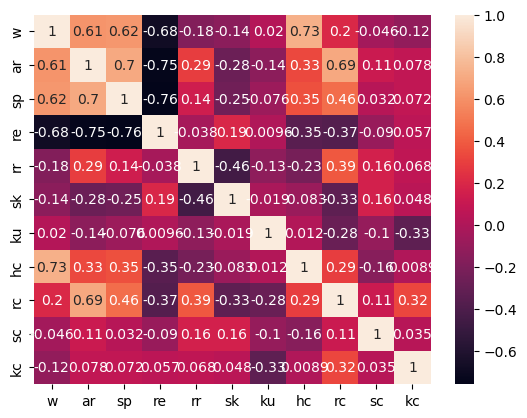

In [8]:
sns.heatmap(df[nums].corr(), annot=True)

# 2 &nbsp; `Train`

We will begin by splitting our data into training and testing sets, using a 20% test size:

In [9]:
X = df.select_dtypes(include=['float64']).values
Y = df.select_dtypes(include=['uint8']).values
y = df['type'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

print(f'X_train shape: {X_train.shape} Type: {type(X_train)}')
print(f'X_test  shape: {X_test.shape}  Type: {type(X_test)}')
print(f'y_train shape: {Y_train.shape}  Type: {type(Y_train)}')
print(f'y_test  shape: {Y_test.shape}   Type: {type(Y_test)}')

n_features = X.shape[1]
n_classes = Y.shape[1]
print('number of features: ', n_features)
print('number of classes : ', n_classes)

X_train shape: (175, 11) Type: <class 'numpy.ndarray'>
X_test  shape: (44, 11)  Type: <class 'numpy.ndarray'>
y_train shape: (175, 5)  Type: <class 'numpy.ndarray'>
y_test  shape: (44, 5)   Type: <class 'numpy.ndarray'>
number of features:  11
number of classes :  5


Construct basic artificial neural network (ANN) model with Keras:

explain why relu and sigmoid - sigmoid needed for outet - relu needed earlier due to vanishing gradient problem it does best on (as in reaserch paper)

We will create a functioin of a basic ANN model and then created differenent instances basese on different params, skips, etc.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 6)            72          ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 5)            35          ['dense[0][0]']                  
                                                                                                  
 dense_4 (Dense)                (None, 5)            30          ['dense_2[0][0]']                
                                                                                              

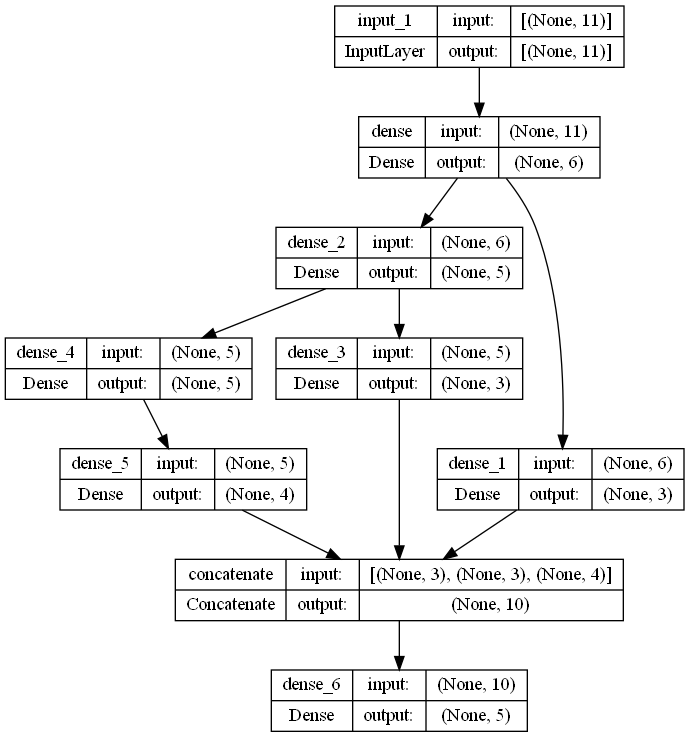

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

def create_keras_model(input_dim=11, output_dim=5, hidden_nodes=[[6, 3], [5, 3], [5, 4]], 
                       optimizer='adam', learning_rate=0.001, regularization_factor=0.01):
    '''
    How to call:
    model_name = create_keras_model(n_features, n_classes, hidden_nodes=[[5, 2], [10, 4], [15, 8]], 
                                    optimizer='adam', learning_rate=0.001, regularization_factor=0.01)
    '''

    # input layer
    inputs = Input(shape=(input_dim,))

    # lists to hold hidden layers
    hidden_layers = []
    compressed_layers = []

    # create hidden layers
    for i in range(len(hidden_nodes)):
        if i == 0:
            # if it's the first hidden layer, connect it to the inputs
            hidden_layers.append(Dense(units=hidden_nodes[i][0], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(inputs))
        else:
            # otherwise, connect it to the previous hidden layer
            hidden_layers.append(Dense(units=hidden_nodes[i][0], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(hidden_layers[-1]))
        
        # compression layer
        compressed_layers.append(Dense(units=hidden_nodes[i][1], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(hidden_layers[-1]))

    # concatenate the compressed layers
    concatenated = concatenate(compressed_layers)

    # output layer, directly connected to the concatenated layer
    outputs = Dense(output_dim, activation='softmax')(concatenated)

    # create model
    model = Model(inputs=inputs, outputs=outputs)

    # define optimizer with the given learning rate
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

    return model

model = create_keras_model(n_features, n_classes, hidden_nodes=[[6, 3], [5, 3], [5, 4]],
                           optimizer='adam', learning_rate=0.001, regularization_factor=0.01)
model.summary()
plot_model(model, show_shapes=True)

In [11]:
# Define early stopping callback
# early_stop1 = EarlyStopping(monitor='val_loss', patience=100)
# Train the model
# model1_fit = model1.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=1, batch_size=1, epochs=1000, callbacks=[early_stop1])

In [12]:
# maxes = []
# for met in model0firstfit.history.keys():
#     maxes.append(max(model0firstfit.history[met]))
# mmax = max(maxes)

# pd.DataFrame(model0firstfit.history).plot(figsize=(9, 5))
# plt.grid(True)
# plt.gca().set_ylim(0, 1.05*mmax)
# plt.show()

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation results across folds
accuracy_scores_train = []
accuracy_scores_test = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Define early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=100)
    # Train the model
    model_fit = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=1, batch_size=1, epochs=1000, callbacks=[early_stop])
    
    # Test your model's performance on the training and test sets
    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)
    
    # Convert the prediction probabilities into class predictions
    y_pred_train = (Y_pred_train > 0.5).astype(int)
    y_pred_test = (Y_pred_test > 0.5).astype(int)
    
    # Evaluate the model's performance on the testing set
    # accuracy_score doesn't work with multilabel output, you need to use some other metric
    # One possibility is average accuracy per class
    accuracy_train = np.mean([accuracy_score(Y_test[:, i], y_pred_train[:, i]) for i in range(Y_test.shape[1])])
    accuracy_test = np.mean([accuracy_score(Y_test[:, i], y_pred_test[:, i]) for i in range(Y_test.shape[1])])
    accuracy_scores_train.append(accuracy_train)
    accuracy_scores_test.append(accuracy_test)
    
# Aggregate the evaluation results across folds
mean_accuracy_train = np.mean(accuracy_scores_train)
mean_accuracy_test = np.mean(accuracy_scores_test)
print(f'Mean training accuracy over {kf.n_splits} folds: {mean_accuracy_train:.3f}')
print(f'Mean testing accuracy over {kf.n_splits} folds: {mean_accuracy_test:.3f}')

Epoch 1/1000
175/175 [==============================] - 2s 5ms/step - loss: 1.6109 - accuracy: 0.2229 - val_loss: 1.6080 - val_accuracy: 0.2045
Epoch 2/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.6058 - accuracy: 0.2286 - val_loss: 1.6080 - val_accuracy: 0.2045
Epoch 3/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.6029 - accuracy: 0.2286 - val_loss: 1.6076 - val_accuracy: 0.2045
Epoch 4/1000
175/175 [==============================] - 0s 2ms/step - loss: 1.6010 - accuracy: 0.2229 - val_loss: 1.6066 - val_accuracy: 0.2045
Epoch 5/1000
175/175 [==============================] - 0s 2ms/step - loss: 1.5985 - accuracy: 0.2400 - val_loss: 1.6035 - val_accuracy: 0.3182
Epoch 6/1000
175/175 [==============================] - 0s 2ms/step - loss: 1.5921 - accuracy: 0.2800 - val_loss: 1.5932 - val_accuracy: 0.2500
Epoch 7/1000
175/175 [==============================] - 0s 2ms/step - loss: 1.5777 - accuracy: 0.3143 - val_loss: 1.5685 - val_accuracy:

ValueError: Found input variables with inconsistent numbers of samples: [44, 175]

In [ ]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# accuracy_scores_train = []
# accuracy_scores_test = []

# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     Y_train, Y_test = Y[train_index], Y[test_index]  # use the same indices for your dummy variables
    
#     # Define early stopping callback
#     early_stop = EarlyStopping(monitor='val_loss', patience=100)
#     # Train the model
#     model_fit = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=1, batch_size=1, epochs=1000, callbacks=[early_stop])
    
#     # Test your model on the testing set
#     Y_pred_train = model.predict(X_train)
#     Y_pred_test = model.predict(X_test)
    
#     # Convert the prediction probabilities into class predictions
#     y_pred_train = (Y_pred_train > 0.5).astype(int)
#     y_pred_test = (Y_pred_test > 0.5).astype(int)
    
    
#     # Evaluate the model's performance on training and testing set
#     accuracy_train = np.mean([accuracy_score(Y_train[:, i], y_pred_train[:, i]) for i in range(Y_train.shape[1])])
#     accuracy_test = np.mean([accuracy_score(Y_test[:, i], y_pred_test[:, i]) for i in range(Y_test.shape[1])])
#     accuracy_scores_train.append(accuracy_train)
#     accuracy_scores_test.append(accuracy_test)
    
# # Aggregate the evaluation results across folds
# mean_accuracy_train = np.mean(accuracy_scores_train)
# mean_accuracy_test = np.mean(accuracy_scores_test)
# print(f'Mean training accuracy over {kf.n_splits} folds: {mean_accuracy_train:.3f}')
# print(f'Mean testing accuracy over {kf.n_splits} folds: {mean_accuracy_test:.3f}')

Epoch 1/1000
175/175 [==============================] - 2s 5ms/step - loss: 1.6106 - accuracy: 0.2229 - val_loss: 1.6059 - val_accuracy: 0.2273
Epoch 2/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.6053 - accuracy: 0.2286 - val_loss: 1.6007 - val_accuracy: 0.2273
Epoch 3/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.5986 - accuracy: 0.2514 - val_loss: 1.5897 - val_accuracy: 0.2273
Epoch 4/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.5828 - accuracy: 0.2800 - val_loss: 1.5635 - val_accuracy: 0.3409
Epoch 5/1000
175/175 [==============================] - 0s 2ms/step - loss: 1.5513 - accuracy: 0.3371 - val_loss: 1.5251 - val_accuracy: 0.3864
Epoch 6/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.5103 - accuracy: 0.3829 - val_loss: 1.4883 - val_accuracy: 0.4318
Epoch 7/1000
175/175 [==============================] - 0s 2ms/step - loss: 1.4678 - accuracy: 0.4343 - val_loss: 1.4437 - val_accuracy:

0.9533615221987315

In [ ]:
# # Wrap Keras model with KerasClassifier
# model = KerasClassifier(build_fn=create_keras_model, verbose=0) #allows for create_keras_model to be called with additional parameters such as epochs and batch_size

# # set parameters
# early_stop = EarlyStopping(monitor='val_loss', patience=100)
# batch_sizes = [0, 1, 2, 4, 8, 16, 32, 64]
# learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5, 1]
# regularization_factors = [0.3, 0.25, 0.2, 0.15, 0.1, 0.5, 0.01, 0.05, 0.001, 0.0005]
# # batch_sizes = [0, 1, 2, 3, 4, 8, 10, 16, 32, 64, 128, 256, 512]
# # learning_rates = [0.001]
# # regularization_factors = [0.01]
# param_grid = dict(batch_size=batch_sizes, learning_rate=learning_rates, regularization_factor=regularization_factors)

# # Create Grid Search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, Y_train, callbacks=[early_stop])

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
# # create dataframe from cv_results_
# df = pd.DataFrame(grid_result.cv_results_)

# # pivot as prep for heatmap
# df_pivot = df.pivot(index='param_batch_size', columns='param_epochs', values='mean_test_score')

# # create heatmap
# fig, ax = plt.subplots(figsize=(9, 5))
# sns.heatmap(df_pivot, annot=True, cmap="YlGnBu")
# ax.set_title('Accuracy Heatmap')
# ax.set_ylabel('Batch Size')
# ax.set_xlabel('Epochs')

In [ ]:
# from sklearn.metrics import accuracy_score

# # get predictions
# y_pred = grid.predict(X_test)

# # get accuracy
# acc = accuracy_score(Y_test, y_pred)

# # print accuracy
# print('Accuracy:', acc)

# # print best parameters
# print('Best Parameters:', grid.best_params_)


# from sklearn.metrics import confusion_matrix

# # predict classes for test set
# Y_pred = model.predict(X_test)
# y_pred = np.argmax(Y_pred, axis=1)

# # convert one-hot encoded test labels back to class labels
# y_true = np.argmax(Y_test, axis=1)

# # calculate confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=types, yticklabels=types)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

In [ ]:
# from sklearn.metrics import classification_report

# # print classification report
# print(classification_report(y_true, y_pred, target_names=types))

In [ ]:
end_time = time.time()
print(f'Total runtime of this notebook is {(end_time-start_time)/60:0.2f} minutes.')

Total runtime of this notebook is 13.37 minutes.
